Robbery frames: 400
Normal frames: 400

===== MODEL PERFORMANCE =====
Accuracy: 84.17 %

Confusion Matrix:
[[ 97  23]
 [ 15 105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       120
           1       0.82      0.88      0.85       120

    accuracy                           0.84       240
   macro avg       0.84      0.84      0.84       240
weighted avg       0.84      0.84      0.84       240



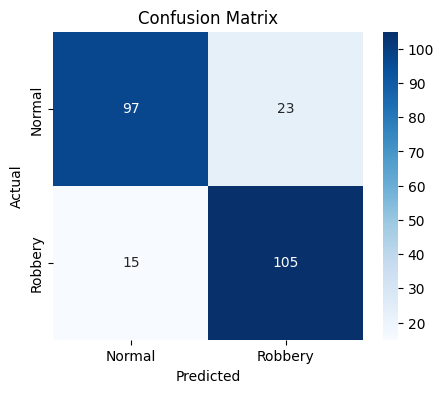

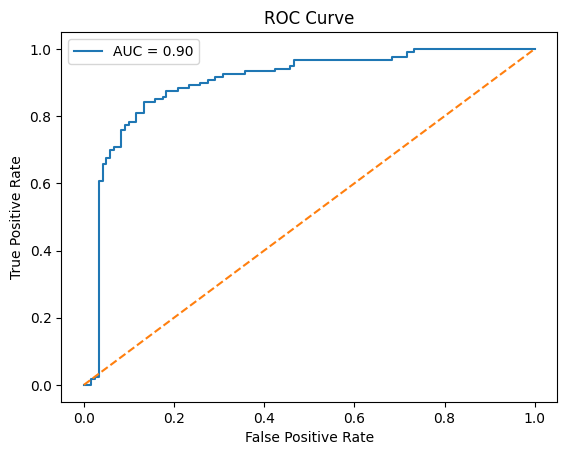

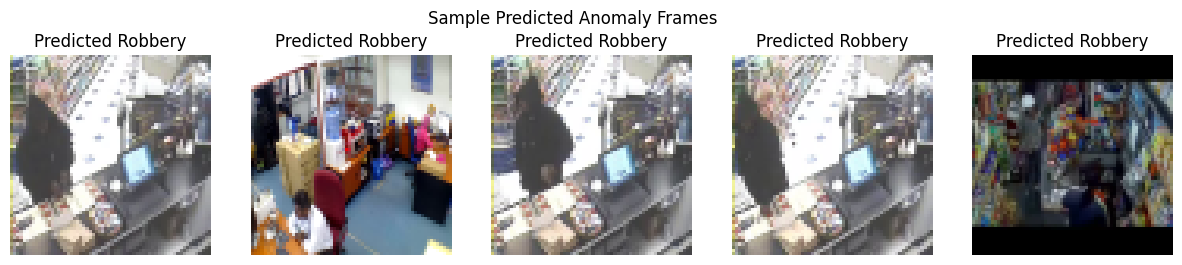

In [1]:
# ======================================
# ADVANCED MOTION + OPTICAL FLOW MODEL
# ======================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# ----------------------------------
# Dataset Paths
# ----------------------------------

robbery_path = "/kaggle/input/ucf-crime-dataset/Train/Robbery"
normal_path = "/kaggle/input/ucf-crime-dataset/Train/NormalVideos"

robbery_imgs = sorted(os.listdir(robbery_path))[:400]
normal_imgs = sorted(os.listdir(normal_path))[:400]

print("Robbery frames:", len(robbery_imgs))
print("Normal frames:", len(normal_imgs))


# ----------------------------------
# Feature Extraction
# ----------------------------------

def extract_features(image_list, folder):
    features = []
    frame_paths = []
    prev_gray = None

    for img_name in image_list:
        img_path = os.path.join(folder, img_name)
        frame = cv2.imread(img_path)

        if frame is None:
            continue

        frame = cv2.resize(frame, (128, 128))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_gray is None:
            prev_gray = gray
            continue

        # Frame Difference
        diff = cv2.absdiff(prev_gray, gray)

        mean_motion = np.mean(diff)
        std_motion = np.std(diff)
        max_motion = np.max(diff)
        motion_ratio = np.sum(diff > 25) / diff.size

        # Optical Flow
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, gray,
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )

        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mean_flow = np.mean(mag)

        features.append([
            mean_motion,
            std_motion,
            max_motion,
            motion_ratio,
            mean_flow
        ])

        frame_paths.append(img_path)
        prev_gray = gray

    return features, frame_paths


# Extract features
robbery_features, robbery_paths = extract_features(robbery_imgs, robbery_path)
normal_features, normal_paths = extract_features(normal_imgs, normal_path)

X = np.array(robbery_features + normal_features)
y = np.array([1]*len(robbery_features) + [0]*len(normal_features))
paths = robbery_paths + normal_paths


# ----------------------------------
# Train/Test Split
# ----------------------------------

X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, paths,
    test_size=0.3,
    random_state=42,
    stratify=y
)


# ----------------------------------
# Train SVM (RBF Kernel)
# ----------------------------------

model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
model.fit(X_train, y_train)


# ----------------------------------
# Evaluation
# ----------------------------------

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n===== MODEL PERFORMANCE =====")
print("Accuracy:", round(accuracy*100, 2), "%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ----------------------------------
# Confusion Matrix Heatmap
# ----------------------------------

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Robbery"],
            yticklabels=["Normal", "Robbery"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ----------------------------------
# ROC Curve
# ----------------------------------

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# ----------------------------------
# Show Predicted Anomaly Frames
# ----------------------------------

anomaly_indices = np.where(y_pred == 1)[0][:5]

plt.figure(figsize=(15,3))

for i, idx in enumerate(anomaly_indices):
    img = cv2.imread(paths_test[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title("Predicted Robbery")
    plt.axis("off")

plt.suptitle("Sample Predicted Anomaly Frames")
plt.show()
